# 뉴스 기사 요약봇

- [뉴스 기사 데이터](https://github.com/sunnysai12345/News_Summary)

In [118]:
import os
import re
import time
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
import requests
import warnings
warnings.filterwarnings(action='ignore')

from attention import AttentionLayer
from summa.summarizer import summarize

import multiprocessing as mp
from multiprocessing import Pool
from functools import partial

from bs4 import BeautifulSoup

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 데이터 로드

In [3]:
# 데이터 로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

,headlines,text
14292,My lawyer advised me not to talk to media: Nan...,Addressing sexual harassment allegations again...
53631,Outer wall of Lucknow Haj House painted saffro...,The green-and-white exterior wall of Haj House...
11073,"Projections wrong, CM's health better: Goa Cab...",Goa Cabinet Minister Vijai Sardesai on Sunday ...
31171,Ask PM Modi to stop threatening Cong leaders: ...,Former PM Manmohan Singh has written to Presid...
24259,BBC mistakes Imran Khan for Wasim Akram in ele...,BBC Newsnight mistook ex-Pakistan captain Imra...
6945,Woman's lip swells thrice its size after injec...,UK's 29-year-old Rachael Knappier's upper lip ...
18366,The Conjuring's spin-off 'The Nun' hits theatres,"The Conjuring's spin-off 'The Nun', which rele..."
15263,Delhi Police recover robbed SUV in 30 minutes ...,"The Delhi Police on Saturday chased two men, w..."
75714,"BSF fights snakes, scorpions at Pak border: Of...",The soldiers of the Border Security Force (BSF...
96111,Pitch criticism in India was defence mechanism...,Former Bangladesh coach Dav Whatmore has said ...


## 데이터 전처리

- 1) 중복값, 결측치 처리
- 2) 텍스트 정규화
    - 불용어 제거는 하지 않는다.
- 3) 소문자 변환, 특수 문자 제거
- 4) 문장 최대 길이 설정

In [5]:
data.describe()

,headlines,text
count,98401,98401
unique,98280,98360
top,Warne produced 'ball of century' with his 1st ...,Virender Sehwag was captaining India when he h...
freq,3,2


In [6]:
# text 중복 제거
data.drop_duplicates(subset=['text'], inplace=True)

data.describe()

,headlines,text
count,98360,98360
unique,98262,98360
top,Don Bradman once scored 100 runs in 3 overs,South Korean company Neofect has unveiled a sm...
freq,3,1


In [7]:
# 결측치 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 텍스트 정규화

In [8]:
# 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [ ]:
# 불용어 리스트
# 사용하지 않음
# print('불용어 개수 :', len(stopwords.words('english') ))
# print(stopwords.words('english'))

### 소문자 변환, 특수문자 제거

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=False):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = re.sub("'",'', sentence) # 따옴표 ' 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    
    # 불용어 제거 시
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 시(default)
    else:
        tokens = ' '.join(word for word in sentence.split())
    return tokens

In [10]:
# 전처리 함수 test
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

# 불용어를 제거하지 않습니다.
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary))  

everything i bought was great infact i ordered twice and the third ordered was br for my mother and father
great way to start the day


In [12]:
start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환
def appendTexts(sentences, remove_stopwords=False):
    texts = []
    for s in sentences:
        texts.append(preprocess_sentence(s))
    return texts


def preprocess_data(data, remove_stopwords=False):
    start_time = time.time()
    
    # 컴퓨터의 코어 수를 구합니다
    num_cores = mp.cpu_count()  

    # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    text_data_split = np.array_split(data, num_cores) 
    pool = Pool(num_cores)

    # 각자 작업한 데이터를 하나로 합쳐줍니다
    processed_data = np.concatenate(pool.map(partial(appendTexts), text_data_split))
    pool.close()
    pool.join()
    
    print(time.time() - start_time, " seconds")
    return processed_data

In [13]:
clean_text = preprocess_data(data['text'])
print(clean_text)

clean_summary = preprocess_data(data['headlines'])
print(clean_summary)

1.4248249530792236  seconds
['saurav kant an alumnus of upgrad and iiit bs pg program in machine learning and artificial intelligence was a sr systems engineer at infosys with almost years of work experience the program and upgrads degree career support helped him transition to a data scientist at tech mahindra with salary hike upgrads online power learning has powered lakh careers'
 'kunal shahs credit card bill payment platform cred gave users a chance to win free food from swiggy for one year pranav kaushik a delhi techie bagged this reward after spending cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult fit and more'
 'new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five match odi series india lost an international match under rohit sharmas captaincy after consecutive victories dating back to march the match witnessed india getti

In [14]:
data['text'] = clean_text
data['headlines'] = clean_summary

data.head()

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant an alumnus of upgrad and iiit bs p...
1,delhi techie wins free food from swiggy for on...,kunal shahs credit card bill payment platform ...
2,new zealand end rohit sharma led indias match ...,new zealand defeated india by wickets in the f...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...
4,have known hirani for yrs what if metoo claims...,speaking about the sexual harassment allegatio...


In [15]:
data.describe()

,headlines,text
count,98360,98360
unique,98170,98330
top,worlds richest people lose billion in one day,former pakistani all rounder shahid afridi sma...
freq,4,2


### 한번 더 중복 & 결측치 처리

In [16]:
data.drop_duplicates(subset=['text'], inplace=True)

data.describe()

,headlines,text
count,98330,98330
unique,98153,98330
top,amazon invests crore in indian payments arm am...,as many as countries will be celebrating azadi...
freq,4,1


In [17]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 문장 최대 길이 설정

In [18]:
# 길이의 분포 시각화해보기
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 69
텍스트의 평균 길이 : 57.731831587511444
요약의 최소 길이 : 1
요약의 최대 길이 : 17
요약의 평균 길이 : 9.422495677819587


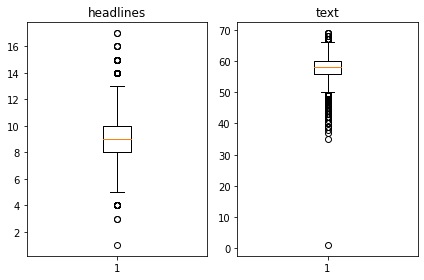

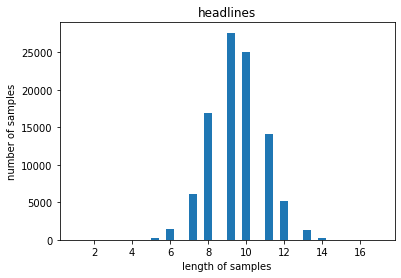

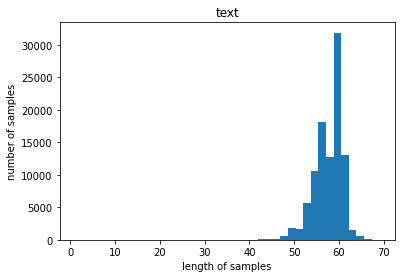

In [19]:
plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [100]:
# 모든 데이터를 포함하는 최대값을 설정
text_max_len = 80
summary_max_len = 18

In [25]:
# text_len이 가장 작은 data의 index 확인해보기
np.argmin(text_len)

52

In [38]:
data.loc[data.index == 52]

,headlines,text
52,headlines,text


의미 없는 데이터이므로 삭제

In [40]:
data.drop(axis=0, index=52, inplace=True)

data.describe()

,headlines,text
count,98329,98329
unique,98152,98329
top,amazon invests crore in indian payments arm am...,as many as countries will be celebrating azadi...
freq,4,1


한번 더 길이 분포 확인해보기

In [ ]:
# 길이의 분포 시각화해보기
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

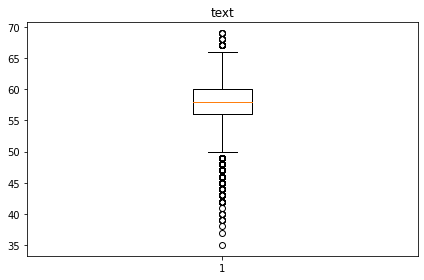

In [42]:
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

## Encoder & Decoder 생성

In [43]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant an alumnus of upgrad and iiit bs p...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shahs credit card bill payment platform ...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led indias match ...,new zealand defeated india by wickets in the f...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led indias match ...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking about the sexual harassment allegatio...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [46]:
data.describe()

,headlines,text,decoder_input,decoder_target
count,98329,98329,98329,98329
unique,98152,98329,98152,98152
top,amazon invests crore in indian payments arm am...,as many as countries will be celebrating azadi...,sostoken amazon invests crore in indian paymen...,worlds richest people lose billion in one day ...
freq,4,1,4,4


In [44]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

## Train, test dataset split

In [48]:
encoder_input_train, encoder_input_test = train_test_split(encoder_input, test_size=0.2, random_state=53)

print('encoder_input_train: ', len(encoder_input_train))
print('encoder_input_test: ', len(encoder_input_test))

encoder_input_train:  78663
encoder_input_test:  19666


In [50]:
decoder_input_train, decoder_input_test = train_test_split(decoder_input, test_size=0.2, random_state=53)

print('decoder_input_train: ', len(decoder_input_train))
print('decoder_input_test: ', len(decoder_input_test))

decoder_input_train:  78663
decoder_input_test:  19666


In [51]:
decoder_target_train, decoder_target_test = train_test_split(decoder_target, test_size=0.2, random_state=53)

print('decoder_target_train: ', len(decoder_target_train))
print('decoder_target_test: ', len(decoder_target_test))

decoder_target_train:  78663
decoder_target_test:  19666


### Word Dictionary 만들기

In [85]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [86]:
src_tokenizer.word_counts

OrderedDict([('a', 110901),
             ('video', 3457),
             ('of', 96977),
             ('ukraine', 102),
             ('restaurant', 371),
             ('has', 45133),
             ('gone', 697),
             ('viral', 624),
             ('on', 57785),
             ('social', 1918),
             ('media', 2537),
             ('where', 2399),
             ('two', 8239),
             ('waiters', 12),
             ('threw', 201),
             ('cakes', 16),
             ('one', 6790),
             ('after', 22758),
             ('the', 270425),
             ('other', 3949),
             ('female', 912),
             ('customers', 687),
             ('who', 15693),
             ('were', 13167),
             ('rude', 22),
             ('to', 116379),
             ('them', 4556),
             ('they', 7970),
             ('smashed', 217),
             ('women', 2954),
             ('said', 43175),
             ('why', 990),
             ('f', 300),
             ('would', 5361),
 

### Word Count 분포 및 빈도 확인

In [79]:
counts = [cnt for word, cnt in original_dict.items()]
words = [word for word, cnt in original_dict.items()]

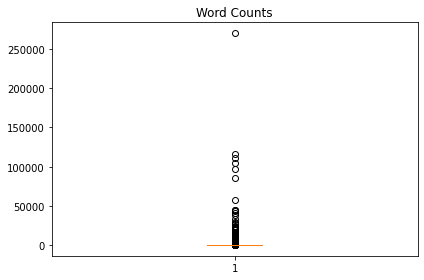

In [62]:
plt.boxplot(counts)
plt.title('Word Counts Distribution')
plt.tight_layout()
plt.show()

In [75]:
for i, c in enumerate(counts):
    if c > 200000:
        print('index:', i, 'count:', c)

index: 18 count: 270425


In [81]:
words[18]

'the'

In [87]:
# 빈도수가 7회 미만인 단어들이 얼마나 되는지 확인
threshold = 10
total_cnt = len(src_tokenizer.word_index)

# 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
rare_cnt = 0

# 훈련 데이터의 전체 단어 빈도수 총 합
total_freq = 0

# 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합
rare_freq = 0


for k, v in src_tokenizer.word_counts.items():
    total_freq += v
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if v < threshold:
        rare_cnt += 1
        rare_freq += v
        
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 73895
등장 빈도가 9번 이하인 희귀 단어의 수: 54887
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19008
단어 집합에서 희귀 단어의 비율: 74.27701468299614
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.937338610943975


In [88]:
src_vocab = 19008

src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [89]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3, 126, 5, 3, 4504, 1556, 8, 806, 914, 7, 242, 187, 199, 54, 16546, 2659, 14269, 61, 18, 1, 104, 7, 54, 614, 818, 28, 35, 11910, 2, 94, 56, 2487, 1, 14269, 18, 61, 5, 1, 155, 10, 553, 1, 1889, 77, 40, 3128, 379, 4436, 32, 962, 12, 245, 3499, 32, 2953, 22, 61, 5, 1, 16546], [703, 200, 6, 340, 5, 5173, 184, 1736, 1797, 2864, 2461, 8, 10, 11, 81, 26, 2, 384, 2, 389, 2, 1590, 793, 81, 1291, 5, 26, 2, 11911, 4, 336, 2, 2384, 11, 998, 14, 30, 2461, 41, 4717, 51, 389, 6809, 6, 5266, 11, 4, 336, 2, 26, 1327, 4, 389, 1, 681, 5, 4153, 765, 25, 6976], [315, 4, 1159, 26, 699, 3, 9322, 2109, 122, 1824, 11, 80, 1476, 71, 1108, 7436, 16547, 4, 1, 126, 1, 4998, 2109, 13, 245, 239, 2, 16548, 3, 4104, 5, 16, 29, 11616, 1469, 6, 10374, 21, 93, 1, 1634, 1, 2109, 13, 982, 9, 4466, 5, 2924, 9, 6887, 5036, 216, 20, 2808, 783, 6, 5708]]


### headline 데이터에 동일한 작업 수행

In [90]:
# summary data에 동일한 작업 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [96]:
threshold = 4
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31895
등장 빈도가 3번 이하인 희귀 단어의 수: 18253
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 13642
단어 집합에서 희귀 단어의 비율: 57.22840570622355
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3454728178809


In [97]:
tar_vocab = 13642
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input ',decoder_input_train[:5])
print('decoder ',decoder_target_train[:5])

input  [[1, 11937, 2307, 9050, 7, 8449, 518, 763, 11, 3029, 1428], [1, 147, 53, 3, 280, 3, 322, 3, 808, 588, 2261, 1395], [1, 7406, 967, 91, 81, 3475, 1678, 11938, 103], [1, 376, 92, 103, 5, 18, 4110, 22, 4111, 719, 448], [1, 291, 10751, 30, 13, 106, 12, 1049, 374]]
decoder  [[11937, 2307, 9050, 7, 8449, 518, 763, 11, 3029, 1428, 2], [147, 53, 3, 280, 3, 322, 3, 808, 588, 2261, 1395, 2], [7406, 967, 91, 81, 3475, 1678, 11938, 103, 2], [376, 92, 103, 5, 18, 4110, 22, 4111, 719, 448, 2], [291, 10751, 30, 13, 106, 12, 1049, 374, 2]]


In [98]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78663
훈련 레이블의 개수 : 78663
테스트 데이터의 개수 : 19666
테스트 레이블의 개수 : 19666


## 패딩 추가

In [101]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')

decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

<hr>

<br>

## 모델 설계: seq2seq + Attention

In [102]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256     # hidden state의 크기

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [103]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [105]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

In [106]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 128)      2433024     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 모델 학습

In [107]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [108]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 416s 1s/step - loss: 4.4557 - val_loss: 3.6868
Epoch 2/50
308/308 [==============================] - 400s 1s/step - loss: 3.6633 - val_loss: 3.4410
Epoch 3/50
308/308 [==============================] - 401s 1s/step - loss: 3.4071 - val_loss: 3.2492
Epoch 4/50
308/308 [==============================] - 394s 1s/step - loss: 3.2061 - val_loss: 3.1068
Epoch 5/50
308/308 [==============================] - 393s 1s/step - loss: 3.0488 - val_loss: 3.0182
Epoch 6/50
308/308 [==============================] - 390s 1s/step - loss: 2.9201 - val_loss: 2.9321
Epoch 7/50
308/308 [==============================] - 393s 1s/step - loss: 2.8127 - val_loss: 2.8598
Epoch 8/50
308/308 [==============================] - 392s 1s/step - loss: 2.7143 - val_loss: 2.7963
Epoch 9/50
308/308 [==============================] - 393s 1s/step - loss: 2.6346 - val_loss: 2.7605
Epoch 10/50
308/308 [==============================] - 393s 1s/step - loss: 2.5540 - val_lo

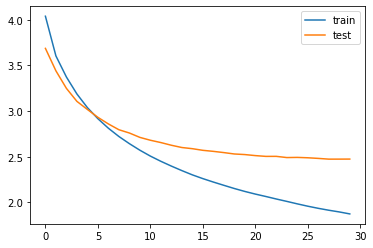

In [109]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [110]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [111]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [112]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [113]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

<hr>

<br>


## 모델 검증, 성능 확인

In [114]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp


# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [140]:
for i in range(70, 80):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : three billboards outside missouri on monday won the best motion picture award in the drama category at this years th golden globe awards the film also won another major award when frances was named best actress in the the drama category meanwhile gary won the best actor in the drama category for darkest hour 
실제 요약 : three billboards named best picture at golden globes 
예측 요약 :  wins best actor award for best actor at iifa awards


원문 : describing the security across the loc as tense a united nations official has said that the un military observer group in india and pakistan is investigating alleged ceasefire violations in the pok the un continues to the need for the parties to find a peaceful solution through engagement and dialogue he added 
실제 요약 : un group probing ceasefire violations in pok official 
예측 요약 :  un calls for india india over ceasefire un


원문 : british singer zayn malik has revealed that his favourite bollywood song is chaiyya chaiyya from shah rukh khan starrer

### 추출적 요약

In [150]:
for i in range(60, 70):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("간편 요약 :", summarize(data['text'][i]))
    print("\n")

원문 : the finance ministry on wednesday said the government will present an interim budget on february the clarification came amid speculations that a full budget may be presented during the session the government recently assigned piyush goyal temporary additional charge of the finance and corporate affairs ministries in the absence of arun jaitley who is in the us for treatment
실제 요약 : govt to present interim budget not full budget on february
간편 요약 : 


원문 : us president donald trump on wednesday called his countrys top intelligence chiefs naive and wrong on iran and added that they should perhaps go back to school trump claimed iran is testing rockets calling the country a source of potential danger and conflict top us intelligence officials on tuesday said that iran isnt currently taking steps towards building nuclear weapons
실제 요약 : us intelligence naive and wrong should go back to school trump
간편 요약 : 


원문 : a senior priest at the vatican who handled cases of sexual abuse has qu

### 데이터를 다시 로드해서 재시도

In [151]:
# 데이터 로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [153]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [161]:
for i in range(60, 70):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("간편 요약 :", summarize(data['text'][i]))
    print("\n")

원문 : The Finance Ministry on Wednesday said the government will present an Interim Budget on February 1. The clarification came amid speculations that a full Budget may be presented during the session. The government recently assigned Piyush Goyal temporary additional charge of the Finance and Corporate Affairs ministries in the absence of Arun Jaitley, who is in the US for treatment.
실제 요약 : Govt to present Interim Budget, not full Budget on February 1
간편 요약 : 


원문 : US President Donald Trump on Wednesday called his country's top intelligence chiefs "naive" and "wrong" on Iran and added that they should perhaps "go back to school". Trump claimed Iran is testing rockets, calling the country "a source of potential danger and conflict". Top US intelligence officials on Tuesday said that Iran isn't currently taking steps towards building nuclear weapons.
실제 요약 : US intelligence naive and wrong, should go back to school: Trump
간편 요약 : 


원문 : A senior priest at the Vatican who handled cas

## Conclusion

- summa를 이용한 summarize는 계속 빈 문자열 ''만 출력되었다.
- 도무지 이유를 모르겠다!!! ㅠㅠ

- 그런데 사실 seq2seq + attention 모델도 성능이 좋진 않았다.
- 더 공부해서 다시 해보자!